In [11]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def segment_words(frame, top_region_percentage=87, bottom_region_percentage=99):
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    _, subtitle_mask = cv2.threshold(gray_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    subtitle_mask = cv2.bitwise_not(subtitle_mask)

    # Apply morphological operations to connect text regions
    kernel = np.ones((5, 5), np.uint8)
    subtitle_mask = cv2.morphologyEx(subtitle_mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the specified region of the mask
    height, width = frame.shape[:2]
    top_region = int(top_region_percentage * height / 100)
    bottom_region = int(bottom_region_percentage * height / 100)

    contours, _ = cv2.findContours(subtitle_mask[top_region:bottom_region, :], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create bounding boxes for each contour
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Adjust y-coordinate to account for the top region offset
        y += top_region

        # Filter out small regions
        if w > 10 and h > 10:
            bounding_boxes.append((x, y, x + w, y + h))

    # Sort bounding boxes based on the y-coordinate to get lines in order
    bounding_boxes.sort(key=lambda box: box[1])

    # Draw bounding boxes on the original frame
    for box in bounding_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

    return frame

In [13]:
def segment_subtitles(frame, top_region=0.93, bottom_region=0.99):
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    _, subtitle_mask = cv2.threshold(gray_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the mask (subtitles should be darker)
    subtitle_mask = cv2.bitwise_not(subtitle_mask)

    # Apply morphological operations to connect text regions
    kernel = np.ones((5, 5), np.uint8)
    subtitle_mask = cv2.morphologyEx(subtitle_mask, cv2.MORPH_CLOSE, kernel)

    # Define the region of interest (ROI) where contours will be detected
    height, width = frame.shape[:2]
    left_offset = int(0.13 * width)
    right_offset = int(0.87 * width)
    top_region_height = int(top_region * height)
    bottom_region_height = int(bottom_region * height)

    # Extract the ROI
    subtitle_roi = subtitle_mask[top_region_height:bottom_region_height, left_offset:right_offset]

    # Find contours in the ROI
    contours, _ = cv2.findContours(subtitle_roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create bounding boxes for each contour
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Adjust coordinates to account for the ROI
        x += left_offset
        y += top_region_height

        # Filter out small regions
        if w > 10 and h > 10:
            bounding_boxes.append((x, y, x + w, y + h))

    # Merge overlapping bounding boxes into single bounding boxes for each line
    merged_boxes = []
    for box in bounding_boxes:
        merged = False
        for i, merged_box in enumerate(merged_boxes):
            if box[1] < merged_box[3] and box[3] > merged_box[1]:
                # Boxes overlap vertically, merge them
                merged_boxes[i] = (min(box[0], merged_box[0]), min(box[1], merged_box[1]),
                                   max(box[2], merged_box[2]), max(box[3], merged_box[3]))
                merged = True
                break
        if not merged:
            merged_boxes.append(box)

    # Draw bounding boxes on the original frame
    for box in merged_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

    return frame

In [14]:
def segment_another_area(frame, top_region=0.87, bottom_region=0.925):
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Apply adaptive thresholding
    _, mask = cv2.threshold(gray_frame, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Invert the mask
    mask = cv2.bitwise_not(mask)

    # Apply morphological operations to connect text regions
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Define the region of interest (ROI) where contours will be detected
    height, width = frame.shape[:2]
    left_offset = int(0.1 * width)
    right_offset = int(0.9 * width)
    top_region_height = int(top_region * height)
    bottom_region_height = int(bottom_region * height)

    # Extract the ROI
    roi = mask[top_region_height:bottom_region_height, left_offset:right_offset]

    # Find contours in the ROI
    contours, _ = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create bounding boxes for each contour
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)

        # Adjust coordinates to account for the ROI
        x += left_offset
        y += top_region_height

        # Filter out small regions
        if w > 10 and h > 10:
            bounding_boxes.append((x, y, x + w, y + h))

    # Merge overlapping bounding boxes into single bounding boxes for each line
    merged_boxes = []
    for box in bounding_boxes:
        merged = False
        for i, merged_box in enumerate(merged_boxes):
            if box[1] < merged_box[3] and box[3] > merged_box[1]:
                # Boxes overlap vertically, merge them
                merged_boxes[i] = (min(box[0], merged_box[0]), min(box[1], merged_box[1]),
                                   max(box[2], merged_box[2]), max(box[3], merged_box[3]))
                merged = True
                break
        if not merged:
            merged_boxes.append(box)

    # Draw bounding boxes on the original frame
    for box in merged_boxes:
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 2)

    return frame


In [15]:
# Specify the video filename
video_filename = 'Project Video.mp4'

# Get the path to the uploaded video file in Colab
video_path = os.path.join('/content/drive/My Drive/image_project', video_filename)

# Open the video file
cap = cv2.VideoCapture(video_path)

# Check if the video file is opened successfully
if not cap.isOpened():
    print(f"Error opening video file: {video_path}")
    exit()

# Create a folder to save frames, processed frames, and segmented frames
output_folder = '/content/frames'
output_processed_folder = '/content/processed_frames'
output_segmented_folder = '/content/segmented_frames_modified_rec'
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_processed_folder, exist_ok=True)
os.makedirs(output_segmented_folder, exist_ok=True)

# Read, process, and segment each frame
frame_number = 0
while True:
    ret, frame = cap.read()

    if not ret:
        break

    # Save the original frame
    original_frame_filename = f"{output_folder}/frame_{frame_number:04d}.jpg"
    cv2.imwrite(original_frame_filename, frame)

    # Convert frame to grayscale if not already in that format
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Save the grayscale frame
    gray_frame_filename = f"{output_processed_folder}/gray_frame_{frame_number:04d}.jpg"
    cv2.imwrite(gray_frame_filename, gray_frame)

    # Apply blurring to reduce noise
    blurred_frame = cv2.GaussianBlur(gray_frame, (5, 5), 0)

    # Save the blurred frame
    blurred_frame_filename = f"{output_processed_folder}/blurred_frame_{frame_number:04d}.jpg"
    cv2.imwrite(blurred_frame_filename, blurred_frame)

    # Apply thresholding to further reduce noise
    _, thresholded_frame = cv2.threshold(blurred_frame, 127, 255, cv2.THRESH_BINARY)

    # Save the thresholded frame
    thresholded_frame_filename = f"{output_processed_folder}/thresholded_frame_{frame_number:04d}.jpg"
    cv2.imwrite(thresholded_frame_filename, thresholded_frame)

    # Segment subtitles
    segmented_frame = segment_words(frame)
    segmented_frame = segment_subtitles(frame)
    segmented_frame = segment_another_area(segmented_frame)


    # Save the segmented frame
    segmented_frame_filename = f"{output_segmented_folder}/segmented_frame_{frame_number:04d}.jpg"
    cv2.imwrite(segmented_frame_filename, segmented_frame)


    frame_number += 1

# Release the video capture object
cap.release()




In [16]:

# Show examples of each preprocessing and segmentation step for a single frame
sample_frame_number = 999
sample_original_frame = cv2.imread(f"{output_folder}/frame_{sample_frame_number:04d}.jpg")
sample_gray_frame = cv2.imread(f"{output_processed_folder}/gray_frame_{sample_frame_number:04d}.jpg")
sample_blurred_frame = cv2.imread(f"{output_processed_folder}/blurred_frame_{sample_frame_number:04d}.jpg")
sample_thresholded_frame = cv2.imread(f"{output_processed_folder}/thresholded_frame_{sample_frame_number:04d}.jpg")
sample_segmented_frame = cv2.imread(f"{output_segmented_folder}/segmented_frame_{sample_frame_number:04d}.jpg")

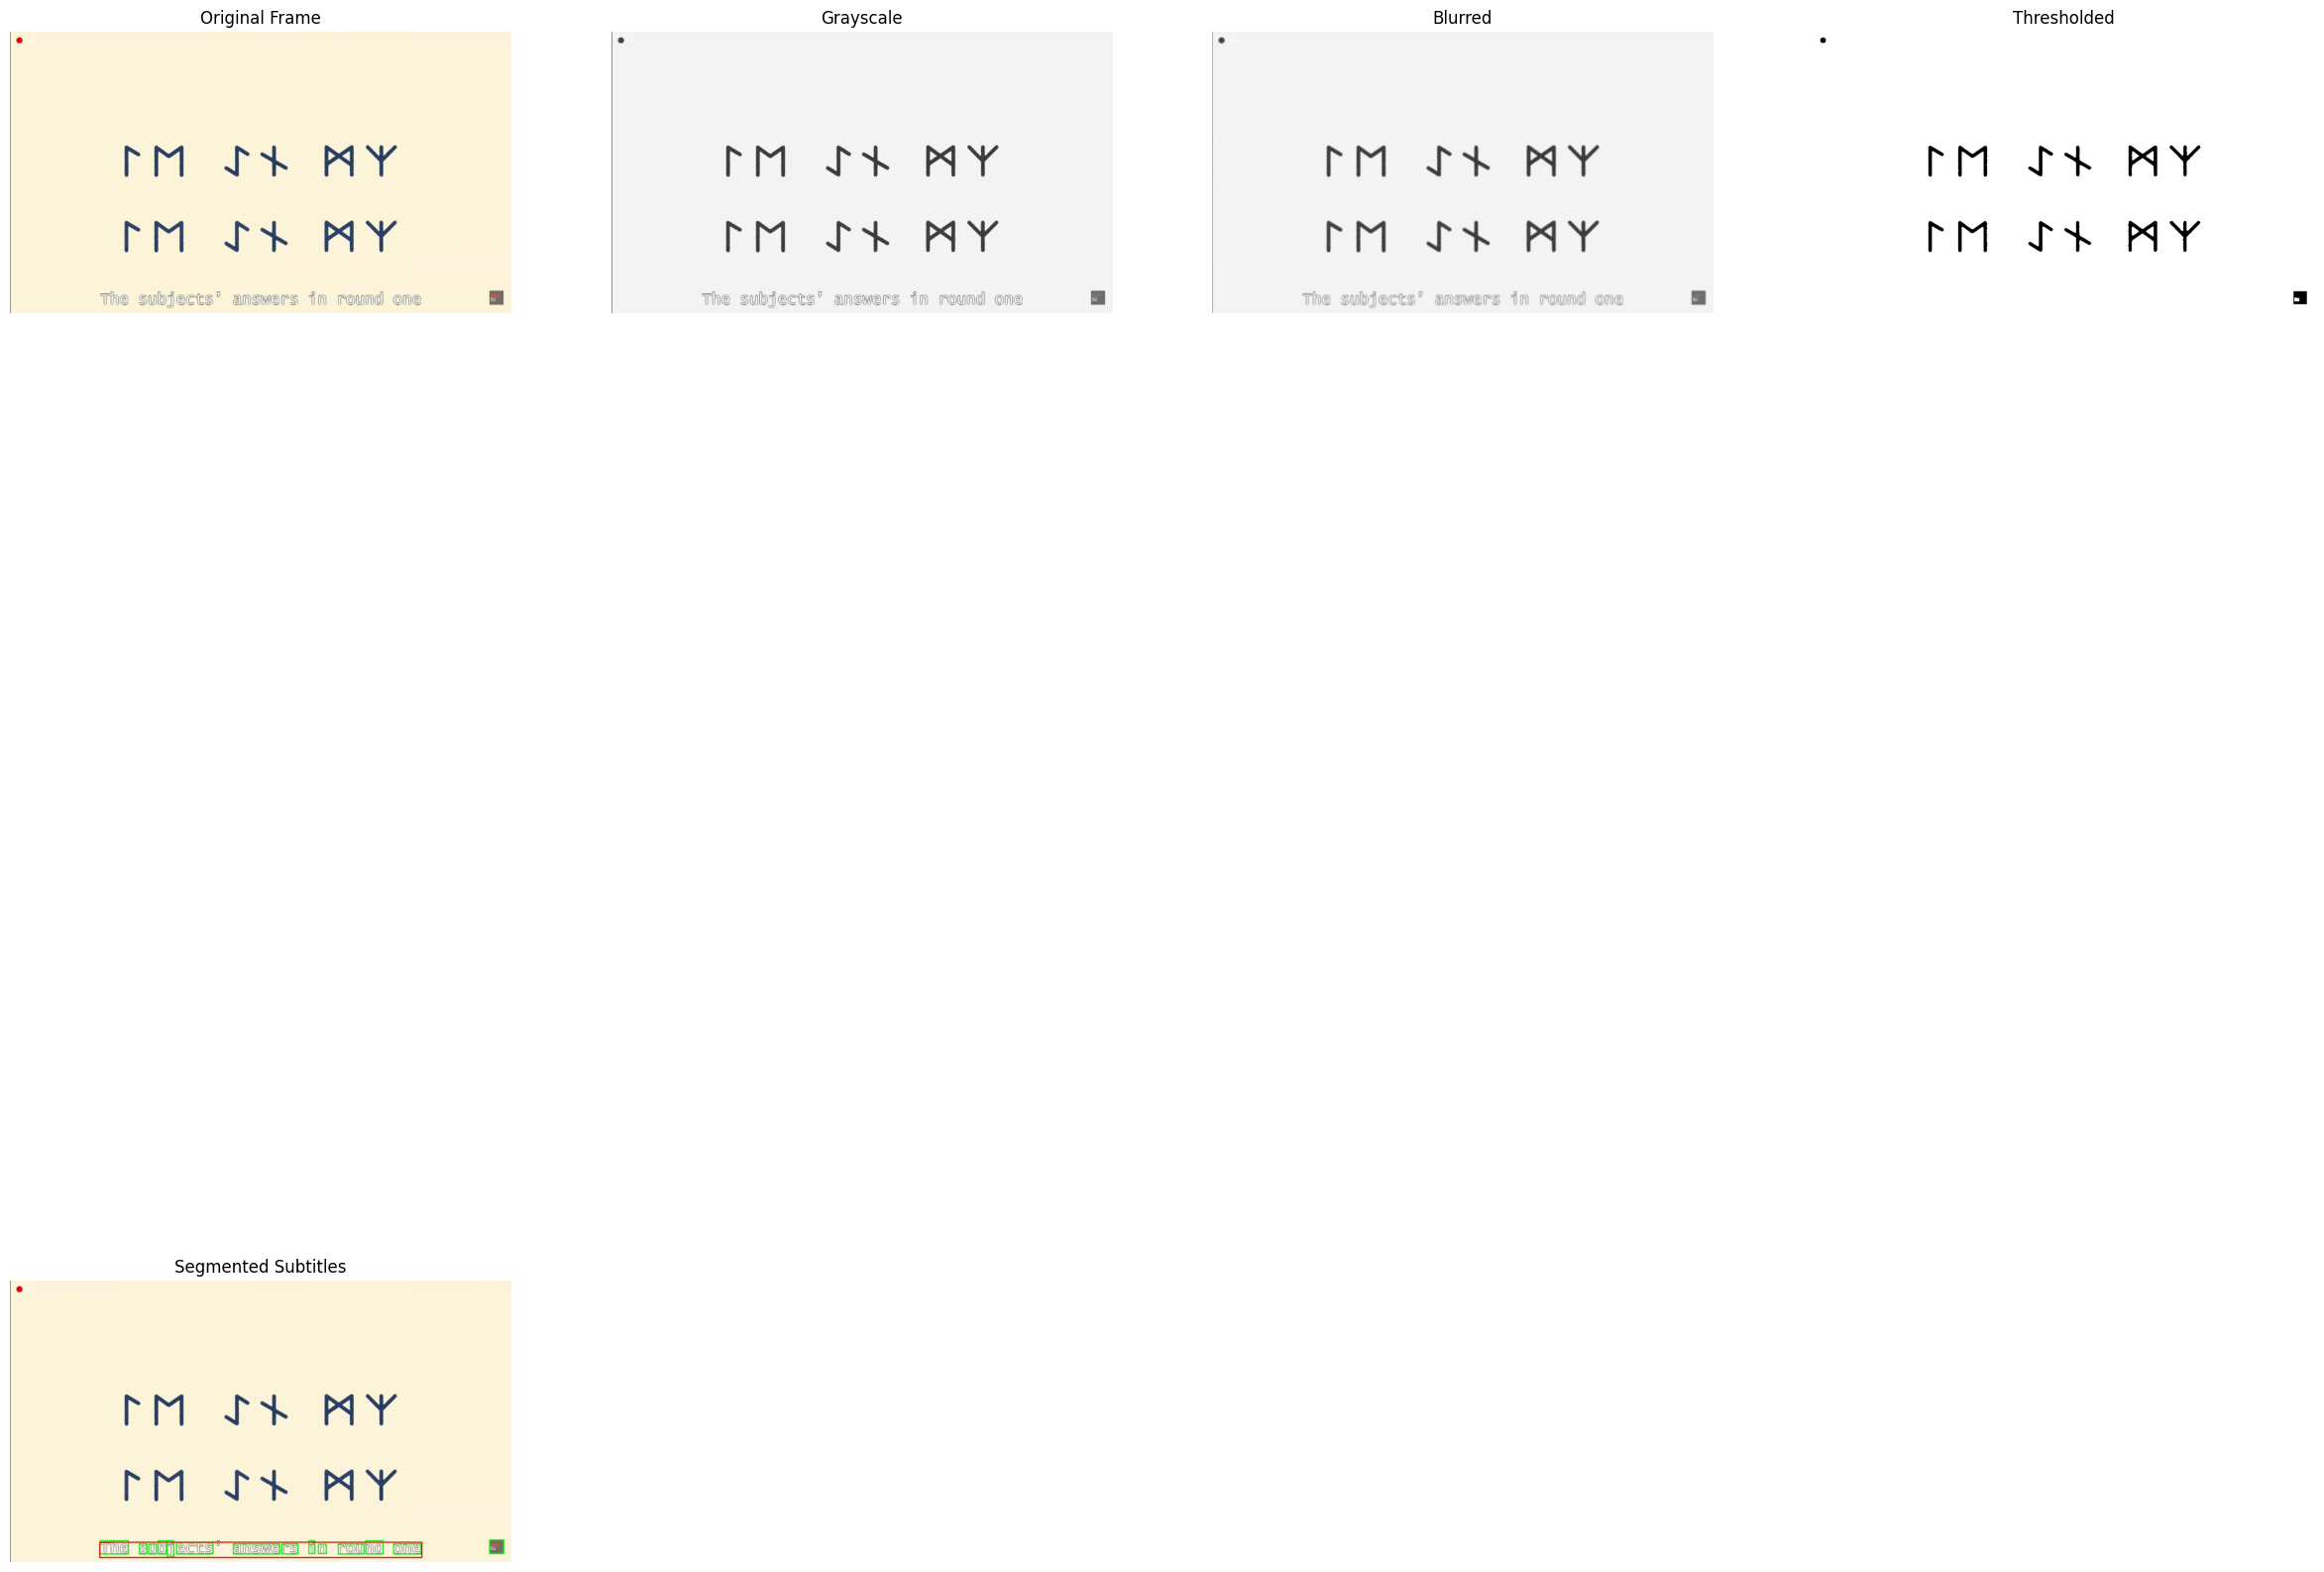

In [17]:
# Plotting the images
plt.figure(figsize=(30, 30))

plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(sample_original_frame, cv2.COLOR_BGR2RGB))
plt.title("Original Frame")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(sample_gray_frame, cmap='gray')
plt.title("Grayscale")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(sample_blurred_frame, cmap='gray')
plt.title("Blurred")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(sample_thresholded_frame, cmap='gray')
plt.title("Thresholded")
plt.axis('off')

plt.subplot(2, 4, 5)
plt.imshow(cv2.cvtColor(sample_segmented_frame, cv2.COLOR_BGR2RGB))
plt.title("Segmented Subtitles")
plt.axis('off')

plt.show()

In [18]:
import cv2
import os

# Path to the folder containing segmented frames
segmented_frames_folder = '/content/segmented_frames_modified_rec'

# Get the list of segmented frame filenames
segmented_frame_filenames = sorted(os.listdir(segmented_frames_folder))

# Specify the output video filename
output_video_filename = '/content/drive/My Drive/image_project/output_video.mp4'

# Get the first segmented frame to determine frame dimensions
first_segmented_frame = cv2.imread(os.path.join(segmented_frames_folder, segmented_frame_filenames[0]))
height, width, _ = first_segmented_frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video = cv2.VideoWriter(output_video_filename, fourcc, 30, (width, height))

# Iterate through segmented frames and add them to the video
for segmented_frame_filename in segmented_frame_filenames:
    segmented_frame_path = os.path.join(segmented_frames_folder, segmented_frame_filename)
    segmented_frame = cv2.imread(segmented_frame_path)
    output_video.write(segmented_frame)

# Release the VideoWriter object
output_video.release()

print(f"Video created successfully: {output_video_filename}")


Video created successfully: /content/drive/My Drive/image_project/output_video.mp4


In [19]:
import shutil


directory_path = '/content/segmented_frames_modified_rec'

# Use shutil.rmtree to remove the directory and its contents
shutil.rmtree(directory_path)
